## Introduction

In this notebook we will use the Tensorflow Recommenders (TFRS) library to build a recommendation system. TFRS is a library for building deep learning recommendation systems. It helps with the full workflow of building a recommendation system: data preparation, model formulation, training, evaluation, and deployment. TFRS is built on top of TensorFlow 2 and Keras, and is designed to be scalable and easy to use.

We are first focusing on a retrieval system, which is a model that predicts a set of movies from the catalogue that the user is likely to watch. We're going to treat the dataset as an implicit system. This means that we are not trying to predict the rating that a user will give to a movie. Instead, we are trying to rank movies by their relevance to the user. This is a common scenario in many recommendation systems, where we are trying to predict the items that a user is most likely to interact with.
Treating Movielens as an implicit system means that we're interpreting users' actions (watching movies) as indicators of their preferences. Specifically:

1. Every movie a user has watched is considered a positive example, indicating that they like or are interested in that movie.
2. Every movie a user hasn't watched is treated as an implicit negative example, implying that they haven't shown interest in it or haven't been exposed to it yet.

This approach helps us make predictions about which movies users might enjoy based on their past behavior without requiring explicit feedback or ratings for each movie.

In a second step we will build a ranking model that predicts the top 10 movies that a user is likely to watch. This model will be trained on the same dataset as the retrieval model, but will be optimized for ranking accuracy rather than relevance.

## Imports

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann

ERROR: Could not find a version that satisfies the requirement scann (from versions: none)
ERROR: No matching distribution found for scann


In [2]:
import os
import pprint
import tempfile
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

## Preprocessing

### Stratified Sampling

In [3]:
# transform pickle file to pandas dataframe
ratings_df = pd.read_pickle('data/df_ratings_cleaned.pkl')
movies_df = pd.read_pickle('data/df_movies_cleaned.pkl')

In [4]:
ratings_df.head()

,userId,movieId,rating,timestamp,user_mean_rating,liked_by_user
0,1,110,1.0,2015-03-09 22:52:09,4.277778,False
1,1,147,4.5,2015-03-09 23:07:15,4.277778,True
2,1,858,5.0,2015-03-09 22:52:03,4.277778,True
3,1,1221,5.0,2015-03-09 22:52:26,4.277778,True
4,1,1246,5.0,2015-03-09 22:52:36,4.277778,True


In [5]:
# nr of entries in the dataset
ratings_df.shape

(24829828, 6)

We will use stratified sampling to downsample the ratings dataset to 100,000 entries. This will help us reduce the size of the dataset while maintaining the distribution of ratings. We will categorize the ratings into bins and sample an equal number of entries from each bin to ensure that the downsampled dataset is representative of the original dataset.

In [6]:
# We will use pandas' cut function to categorize these ratings
ratings_df['rating_category'] = pd.cut(ratings_df['rating'], bins=np.arange(0.5, 6.0, 0.5), include_lowest=True, right=False)

# Stratified sampling based on rating categories
strat_sampled_ratings_df = ratings_df.groupby('rating_category', group_keys=False).apply(
    lambda x: x.sample(int(np.rint(100000 * len(x) / len(ratings_df))), random_state=42)
)

print(f"Original DF Shape: {ratings_df.shape}")
print(f"Sampled DF Shape: {strat_sampled_ratings_df.shape}")

/var/folders/08/34vp8sgn1vj1l_v1dzyhrdk00000gn/T/ipykernel_25106/1716066896.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  strat_sampled_ratings_df = ratings_df.groupby('rating_category', group_keys=False).apply(


Original DF Shape: (24829828, 7)
Sampled DF Shape: (100000, 7)


In [7]:
# Compare summary statistics of the original and downsampled datasets
def summary_stats_comparison(original_df, downsampled_df, column):
    """Compare summary statistics of a column in the original and downsampled datasets."""
    original_stats = original_df[column].describe()
    downsampled_stats = downsampled_df[column].describe()
    
    summary_stats = pd.concat([original_stats, downsampled_stats], axis=1)
    summary_stats.columns = ['Original', 'Sampled']
    
    return summary_stats

summary_stats_comparison(ratings_df, strat_sampled_ratings_df, 'rating')

,Original,Sampled
count,24829828.0,100000.0
mean,3.52898,3.52899
std,1.060177,1.060165
min,0.5,0.5
25%,3.0,3.0
50%,3.5,3.5
75%,4.0,4.0
max,5.0,5.0


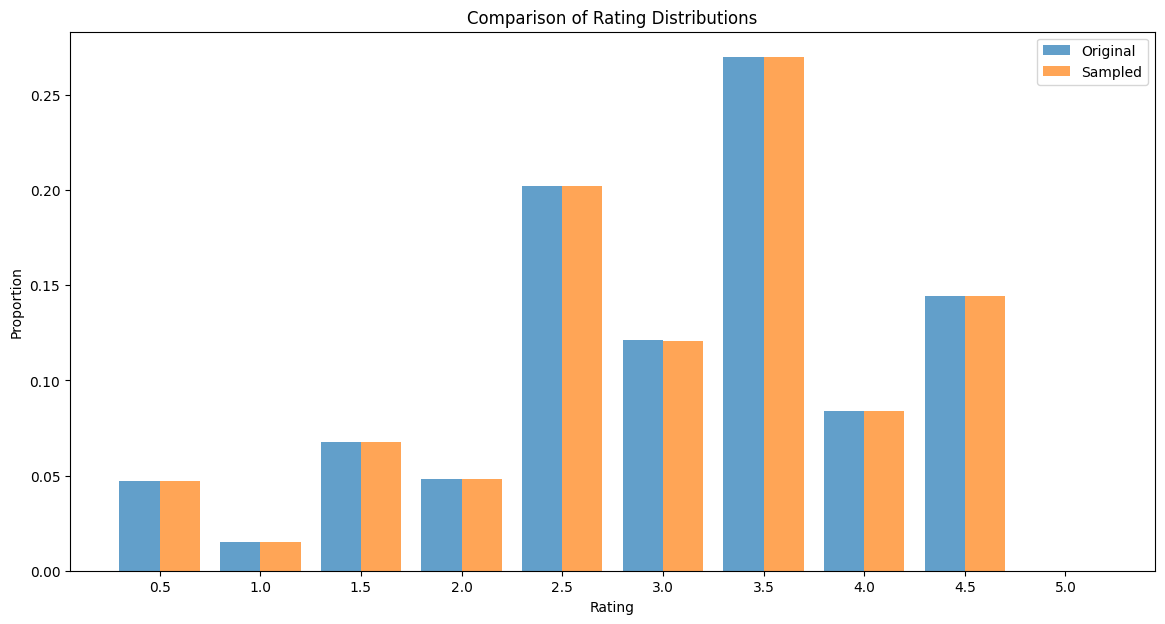

In [8]:
# Define your bins
bins = np.arange(0.5, 6.0, 0.5)

# Calculate bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Define width of each bar
bar_width = 0.2

# Plot histograms
plt.figure(figsize=(14, 7))
plt.bar(bin_centers - bar_width/2, ratings_df['rating'].value_counts(normalize=True, sort=False, bins=bins), width=bar_width, alpha=0.7, label='Original', align='center')
plt.bar(bin_centers + bar_width/2, strat_sampled_ratings_df['rating'].value_counts(normalize=True, sort=False, bins=bins), width=bar_width, alpha=0.7, label='Sampled', align='center')

plt.title('Comparison of Rating Distributions')
plt.xlabel('Rating')
plt.ylabel('Proportion')
plt.xticks(bin_centers, labels=[f"{bin:.1f}" for bin in bins[:-1]])  # Set x-tick labels to match bin centers
plt.legend()
plt.show()

In [9]:
strat_sampled_ratings_df

,userId,movieId,rating,timestamp,user_mean_rating,liked_by_user,rating_category
11800835,128365,1037,0.5,2009-10-19 10:10:37,3.104895,False,"[0.5, 1.0)"
3192182,34770,27316,0.5,2006-06-10 09:14:33,1.329146,False,"[0.5, 1.0)"
10041143,108700,307,0.5,2010-05-12 21:26:12,3.729651,False,"[0.5, 1.0)"
14911364,162680,73929,0.5,2015-11-22 18:22:29,3.505618,False,"[0.5, 1.0)"
13024846,141941,4308,0.5,2006-06-10 05:21:47,2.987685,False,"[0.5, 1.0)"
...,...,...,...,...,...,...,...
2596165,28184,2912,5.0,2000-11-21 00:08:40,3.588011,True,"[5.0, 5.5)"
2174721,23629,1185,5.0,1997-03-13 18:00:11,3.734463,True,"[5.0, 5.5)"
23363519,254448,49272,5.0,2016-08-08 15:59:55,3.819149,True,"[5.0, 5.5)"
19688576,214494,541,5.0,2005-04-05 14:26:59,3.395652,True,"[5.0, 5.5)"


Now we we want to add the movie title to the ratings dataset.

In [10]:
# Convert 'movieId' to string in both DataFrames
strat_sampled_ratings_df['movieId'] = strat_sampled_ratings_df['movieId'].astype(str)
movies_df['movieId'] = movies_df['movieId'].astype(str)

In [11]:
# Joining the DataFrames on 'movieId'
strat_sampled_ratings_df = pd.merge(strat_sampled_ratings_df, movies_df, on='movieId', how='left')
strat_sampled_ratings_df.head()

,userId,movieId,rating,timestamp,user_mean_rating,liked_by_user,rating_category,id_x,imdbId,tmdbId,...,release_date,runtime,title,vote_average,vote_count,actors,keywords_extracted,genre_extracted,production_company_extracted,production_country_extracted
0,128365,1037,0.5,2009-10-19 10:10:37,3.104895,False,"[0.5, 1.0)",10163,104692,10163,...,1992-03-05,108.0,The Lawnmower Man,5.4,198.0,"[Jeff Fahey, Pierce Brosnan, Jenny Wright, Mar...","[dream, chimp, manipulation, botanist, virtual...","[Horror, Thriller, Science Fiction]","[New Line Cinema, Allied Vision]","[United Kingdom, Japan, United States of America]"
1,34770,27316,0.5,2006-06-10 09:14:33,1.329146,False,"[0.5, 1.0)",33253,235154,33253,...,1999-11-19,118.0,6ixtynin9,7.0,18.0,"[Lalita Panyopas, Sirisin Siripornsmathikul, P...","[airport, drug dealer, buddhist, mistaken iden...","[Comedy, Crime, Thriller]","[The Film Factory, Five Stars Production Company]",[Thailand]
2,108700,307,0.5,2010-05-12 21:26:12,3.729651,False,"[0.5, 1.0)",108,108394,108,...,1993-01-10,98.0,Three Colors: Blue,7.7,311.0,"[Juliette Binoche, Benoît Régent, Florence Per...","[paris, composer, pain, loss of husband, to co...","[Drama, Music, Mystery]","[France 3 Cinéma, CED Productions]","[France, Poland]"
3,162680,73929,0.5,2015-11-22 18:22:29,3.505618,False,"[0.5, 1.0)",22894,1038686,22894,...,2010-01-21,100.0,Legion,5.2,643.0,"[Paul Bettany, Dennis Quaid, Kevin Durand, Kat...","[angel, diner, religion, apocalypse, demon, de...",[Horror],[Bold Films],[United States of America]
4,141941,4308,0.5,2006-06-10 05:21:47,2.987685,False,"[0.5, 1.0)",824,203009,824,...,2001-03-09,127.0,Moulin Rouge!,7.4,1348.0,"[Nicole Kidman, Ewan McGregor, John Leguizamo,...","[duke, musical, writer's block, music, termina...","[Drama, Music, Romance]","[Bazmark Films, Twentieth Century Fox Film Cor...","[Australia, United States of America]"


In [12]:
# Keep only the necessary columns
strat_sampled_ratings_df = strat_sampled_ratings_df[['userId', 'movieId', 'rating', 'timestamp', 'title']]

# Rename the 'title' column to 'movie_title'
strat_sampled_ratings_df.rename(columns={'title': 'movie_title'}, inplace=True)

In [13]:
strat_sampled_ratings_df

,userId,movieId,rating,timestamp,movie_title
0,128365,1037,0.5,2009-10-19 10:10:37,The Lawnmower Man
1,34770,27316,0.5,2006-06-10 09:14:33,6ixtynin9
2,108700,307,0.5,2010-05-12 21:26:12,Three Colors: Blue
3,162680,73929,0.5,2015-11-22 18:22:29,Legion
4,141941,4308,0.5,2006-06-10 05:21:47,Moulin Rouge!
...,...,...,...,...,...
99996,28184,2912,5.0,2000-11-21 00:08:40,The Limey
99997,23629,1185,5.0,1997-03-13 18:00:11,My Left Foot: The Story of Christy Brown
99998,254448,49272,5.0,2016-08-08 15:59:55,Casino Royale
99999,214494,541,5.0,2005-04-05 14:26:59,Blade Runner


In [14]:
# Drop missing values
strat_sampled_ratings_df.dropna(inplace=True)

In [15]:
# Save the downsampled dataset to a pickle file
#strat_sampled_ratings_df.to_pickle('data/df_ratings_100k.pkl')

### Adjust Datasets for TFRS Requirements

#### Ratings Dataset

In [16]:
# Show column types
strat_sampled_ratings_df.dtypes

userId                  int64
movieId                object
rating                Float64
timestamp      datetime64[ns]
movie_title            object
dtype: object

In [17]:
# First, ensure movieId and userId are converted to strings (object dtype in pandas)
strat_sampled_ratings_df['movieId'] = strat_sampled_ratings_df['movieId'].astype(str)
strat_sampled_ratings_df['userId'] = strat_sampled_ratings_df['userId'].astype(str)

# Convert 'rating', 'user_mean_rating' to float32 for memory efficiency and compatibility
float_columns = ['rating',]
for col in float_columns:
    strat_sampled_ratings_df[col] = strat_sampled_ratings_df[col].astype('float32')

# Convert 'timestamp' from datetime64[ns] to int64 (UNIX timestamp)
strat_sampled_ratings_df['timestamp'] = strat_sampled_ratings_df['timestamp'].astype('int64') // 10**9

# Print data types to verify
strat_sampled_ratings_df.dtypes

userId          object
movieId         object
rating         float32
timestamp        int64
movie_title     object
dtype: object

In [18]:
# Rename columns for better understanding
strat_sampled_ratings_df = strat_sampled_ratings_df.rename(columns={
    'userId': 'user_id',
    'movieId': 'movie_id',
    'rating': 'user_rating',
    'timestamp': 'timestamp',
    'movie_title': 'movie_title'
})

In [19]:
import tensorflow as tf

def df_to_dataset(dataframe, shuffle=True, batch_size=32, label_column=None):
    dataframe = dataframe.copy()
    dict_slices = {name: values for name, values in dataframe.items() if name != label_column}

    # Handle RaggedTensor conversion for list columns and convert everything else to appropriate format
    def convert_to_appropriate_format(data):
        if isinstance(data.iloc[0], list):  # Handling list specifically for RaggedTensors
            return tf.ragged.constant(data.tolist(), dtype=tf.int64)
        else:
            return data.values

    dict_slices = {name: convert_to_appropriate_format(dataframe[name]) for name in dict_slices}

    if label_column is not None:
        labels = dataframe.pop(label_column).values
        dataset = tf.data.Dataset.from_tensor_slices((dict_slices, labels))
    else:
        dataset = tf.data.Dataset.from_tensor_slices(dict_slices)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))
    dataset = dataset.batch(batch_size)

    # Convert arrays to scalars in each dataset element if batch_size is 1
    if batch_size == 1:
        def to_scalar(batch):
            return {k: tf.squeeze(v, axis=0) for k, v in batch.items()}
        dataset = dataset.map(to_scalar)

    return dataset

In [20]:
# Convert the DataFrame to a TensorFlow Dataset
ratings = df_to_dataset(strat_sampled_ratings_df, batch_size=1, shuffle=False)

In [21]:
# Convert back to a pandas DataFrame only for visualization and checking
ratings_pandas_df = tfds.as_dataframe(ratings)
ratings_pandas_df.head()

2024-05-05 18:11:10.598224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,movie_id,movie_title,timestamp,user_id,user_rating
0,b'1037',b'The Lawnmower Man',1255947037,b'128365',0.5
1,b'27316',b'6ixtynin9',1149930873,b'34770',0.5
2,b'307',b'Three Colors: Blue',1273699572,b'108700',0.5
3,b'73929',b'Legion',1448216549,b'162680',0.5
4,b'4308',b'Moulin Rouge!',1149916907,b'141941',0.5


#### Movies Dataset

In [22]:
# Drop unnecessary columns (all except 'movieId', 'title' and 'genre_extracted')
movies_df = movies_df[['movieId', 'title', 'genre_extracted']]
movies_df.head()

,movieId,title,genre_extracted
0,1,Toy Story,"[Animation, Comedy, Family]"
1,2,Jumanji,"[Adventure, Fantasy, Family]"
2,3,Grumpier Old Men,"[Romance, Comedy]"
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II,[Comedy]


In [23]:
# rename columns for better understanding
movies_df = movies_df.rename(columns={
    'title': 'movie_title',
    'movieId': 'movie_id',
    'genre_extracted': 'movie_genres'
})

In [24]:
# Convert 'movie_id' to string
movies_df['movie_id'] = movies_df['movie_id'].astype(str)

# Ensure 'movie_genres' contains only lists of strings
movies_df['movie_genres'] = movies_df['movie_genres'].apply(lambda x: [str(i) for i in x] if isinstance(x, list) else [])

# Step 1: Safely extract unique genres
unique_genres = set()
for sublist in movies_df['movie_genres']:
    for genre in sublist:
        unique_genres.add(genre)  # This avoids any type error as we ensure each item is a string

# Step 2: Map genres to unique integer identifiers
genre_to_id = {genre: idx for idx, genre in enumerate(unique_genres)}

# Step 3: Replace genres in each movie with their corresponding IDs
movies_df['movie_genres'] = movies_df['movie_genres'].apply(lambda genres: [genre_to_id[genre] for genre in genres])

In [25]:
movies_df.head()

,movie_id,movie_title,movie_genres
0,1,Toy Story,"[17, 4, 2]"
1,2,Jumanji,"[10, 15, 2]"
2,3,Grumpier Old Men,"[20, 4]"
3,4,Waiting to Exhale,"[4, 9, 20]"
4,5,Father of the Bride Part II,[4]


In [26]:
# Convert the DataFrame to a TensorFlow Dataset
movies = df_to_dataset(movies_df, batch_size=1, shuffle=False)

In [27]:
# Convert back to a pandas DataFrame only for visualization and checking
movies_pandas_df = tfds.as_dataframe(movies)
movies_pandas_df.head()

2024-05-05 18:11:13.757461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,movie_genres,movie_id,movie_title
0,"[17, 4, 2]",b'1',b'Toy Story'
1,"[10, 15, 2]",b'2',b'Jumanji'
2,"[20, 4]",b'3',b'Grumpier Old Men'
3,"[4, 9, 20]",b'4',b'Waiting to Exhale'
4,[4],b'5',b'Father of the Bride Part II'


## Preparing the TFRS Dataset

For the TFRS we will use the movielens dataset from [Tensorflow](https://www.tensorflow.org/datasets/catalog/movielens) which is specifically designed to work with TFRS. It is equal to the dataset that was used for the Preprocessing and EDA. However, we will use a subset dataset that is able to run.

- 100k-ratings: This dataset contains 100,000 ratings from 943 users on 1,682 movies. This dataset is the oldest version of the MovieLens dataset.
- 100k-movies: This dataset contains data of 1,682 movies rated in the 100k dataset.

In [28]:
# Ratings data.
ratings_tfrs = tfds.load("movielens/100k-ratings", split="train")

#Movie Data
movies_tfrs = tfds.load("movielens/100k-movies", split="train")

In [29]:
# Transform the dataset to a pandas dataframe
movies_tfrs_df = tfds.as_dataframe(movies_tfrs)
movies_tfrs_df.head()

2024-05-05 18:11:13.997132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,movie_genres,movie_id,movie_title
0,[4],b'1681',b'You So Crazy (1994)'
1,"[4, 7]",b'1457',b'Love Is All There Is (1996)'
2,"[1, 3]",b'500',b'Fly Away Home (1996)'
3,[0],b'838',b'In the Line of Duty 2 (1987)'
4,[7],b'1648',"b'Niagara, Niagara (1997)'"


In this Notebook we only going to focus on the ratings. We keep only the user_id, and movie_title fields in the dataset.

In [30]:
for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'movie_id': b'1037',
 'movie_title': b'The Lawnmower Man',
 'timestamp': 1255947037,
 'user_id': b'128365',
 'user_rating': 0.5}


2024-05-05 18:11:14.013253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [31]:
for x in movies.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'movie_genres': array([17,  4,  2]),
 'movie_id': b'1',
 'movie_title': b'Toy Story'}


2024-05-05 18:11:14.024159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# PROBLEM:

In [32]:
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
})
movies = movies.map(lambda x: {"movie_title": x})

In [33]:
# print the first 3 examples for the ratings dataset
for x in ratings.take(3).as_numpy_iterator():
    pprint.pprint(x)

{'movie_title': b'The Lawnmower Man', 'user_id': b'128365'}
{'movie_title': b'6ixtynin9', 'user_id': b'34770'}
{'movie_title': b'Three Colors: Blue', 'user_id': b'108700'}


2024-05-05 18:11:14.061286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [34]:
# print the first 3 examples for the movies dataset
for x in movies.take(3).as_numpy_iterator():
    pprint.pprint(x)

{'movie_title': {'movie_genres': array([17,  4,  2]),
                 'movie_id': b'1',
                 'movie_title': b'Toy Story'}}
{'movie_title': {'movie_genres': array([10, 15,  2]),
                 'movie_id': b'2',
                 'movie_title': b'Jumanji'}}
{'movie_title': {'movie_genres': array([20,  4]),
                 'movie_id': b'3',
                 'movie_title': b'Grumpier Old Men'}}


2024-05-05 18:11:14.074838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [35]:
# Set the random seed for reproducibility
tf.random.set_seed(42)

# Shuffle the dataset with a specified buffer size and seed
shuffled = ratings.shuffle(buffer_size=99220, seed=42, reshuffle_each_iteration=False)

# Take the first 80,000 examples for the training set (80% of the data)
train = shuffled.take(79_376)

# Skip the first 80,000 examples and take the next 20,000 for the test set (20% of the data)
test = shuffled.skip(79_376).take(19_844)

Lets investigate the unique user ids and movie titles in the dataset.

In [36]:
# Unique user ids and movie titles
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

unique_movie_titles[:10]

2024-05-05 18:11:14.130917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [2], [batch]: [3]


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [2], [batch]: [3] [Op:IteratorGetNext] name: 


The extraction and identification of unique user IDs and movie titles from a dataset are crucial for efficiently managing and processing data in machine learning applications, especially in recommender systems. By converting these categorical labels into unique numerical identifiers, we can optimize memory usage and enhance computational efficiency, which is fundamental for training accurate and scalable models. This preprocessing step also ensures that each entity (user or movie) is uniquely represented, aiding in the precise construction of user-item interaction matrices that are essential for personalization and prediction accuracy in recommendation algorithms.

## Model

We will build a two-tower retrieval model using the TFRS library. This model consists of two separate components or "towers".

A two-tower retrieval model is a type of architecture commonly used in recommendation systems, particularly in the context of information retrieval tasks such as recommending items to users. The "two towers" refer to two separate components or "towers" within the model:

Query Tower: This tower represents the user's query or input. It typically takes user-specific information or features, such as user demographics, past interactions, or explicit preferences, and encodes them into a fixed-length representation.
Candidate Tower: This tower represents the items in the catalog or database that are being considered for recommendation. It takes item-specific information or features, such as item attributes, metadata, or embeddings, and encodes them into a fixed-length representation.
After encoding both the query and candidate items, the model computes a similarity score between them.

In [ ]:
# Decide the dimensionality of the query and candidate representations
embedding_dimension = 32 # Higher values -> more accuracy, but also slower fitting and increased overfitting risks.

# Define the model architecture using Keras preprocessing layers
# Query tower
user_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
    # We add 1 to account for the zero padding in the embedding layer.
    tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

# Candidate tower
movie_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
    tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])

In [ ]:
# Define the metrics for the model
metrics = tfrs.metrics.FactorizedTopK(
    candidates=movies.batch(128).map(movie_model)
)

In [ ]:
# Define the loss function for the model
task = tfrs.tasks.Retrieval(
    metrics=metrics
)

In [ ]:
# Create the retrieval model
class MovieLensModel(tfrs.Model):
    def __init__(self, user_model, movie_model):
        super().__init__()
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        # We pick out the user features and pass them into the user model
        user_embeddings = self.user_model(features["user_id"])
        # And pick out the movie features and pass them into the movie model
        positive_movie_embeddings = self.movie_model(features["movie_title"])

        # The task computes the loss and the metrics
        return self.task(user_embeddings, positive_movie_embeddings)

In [ ]:
class NoBaseClassMovielensModel(tf.keras.Model):

    def __init__(self, user_model, movie_model):
        super().__init__()
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task

    def train_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

        # Set up a gradient tape to record gradients.
        with tf.GradientTape() as tape:

            # Loss computation.
            user_embeddings = self.user_model(features["user_id"])
            positive_movie_embeddings = self.movie_model(features["movie_title"])
            loss = self.task(user_embeddings, positive_movie_embeddings)

            # Handle regularization losses as well.
            regularization_loss = sum(self.losses)

            total_loss = loss + regularization_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss

        return metrics

    def test_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

        # Loss computation.
        user_embeddings = self.user_model(features["user_id"])
        positive_movie_embeddings = self.movie_model(features["movie_title"])
        loss = self.task(user_embeddings, positive_movie_embeddings)

        # Handle regularization losses as well.
        regularization_loss = sum(self.losses)

        total_loss = loss + regularization_loss

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss

        return metrics

In [ ]:
# Create the model
model = MovielensModel(user_model, movie_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Shuffle and batch the datasets
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

# Train the model
model.fit(cached_train, epochs=3)

In [ ]:
# Evaluate the model
model.evaluate(cached_test, return_dict=True)

In [ ]:
# Make predictions with the model
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

# Get recommendations.
_, titles = index(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :3]}")